## PyTorch Demo

Give this ~20 seconds to run, depending on your internet speed

In [17]:
import subprocess
import os
subprocess.call(f'{os.getcwd()}/make_coco.sh')

FileNotFoundError: [Errno 2] No such file or directory: 'chmod 700 make_coco.sh': 'chmod 700 make_coco.sh'

In [13]:
import sys
sys.path.insert(0, 'cocoapi/PythonAPI/')
from pycocotools.coco import COCO
# from pycocotools.coco import COCO
import json
import time
import pandas as pd
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
# import pylab
import torchvision.datasets as dset
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim

In [3]:
dataDir='/datasets/COCO-2017'
dataType='val2017'
annFile='{}/anno2017/instances_{}.json'.format(dataDir,dataType)
with open(annFile, 'r') as f:
    data = json.load(f)
coco = COCO(annFile)

loading annotations into memory...
Done (t=0.69s)
creating index...
index created!


In [4]:
def get_id_dict(data):
    id_dict = {}
    for i, cat in enumerate(data['categories']): 
        id_dict[cat['id']] = i
        cat['id'] = i
    return id_dict

In [5]:
id_dict = get_id_dict(data)

In [6]:
def drop_null_annotations(data, dataDir, dataType, annFile, map_ids=True, save=True):
    """
    Takes in a json.load(f) of an annotation file, finds all image ids without an annotation, then drops those images from the file.
    Writes to a new json file without those images.
    """
    images_pd = pd.Series(data['images'])
    new_images_pd = images_pd.copy()
    new_data = data.copy()
    new_data['images'] = \
        new_images_pd.loc[~images_pd.apply(lambda x: len(coco.getAnnIds(x['id']))==0)].tolist() 
    # sets new_data['images'] to only the list of images with one or more annotations
    if os.path.isdir(dataDir+"/annotations") == False: os.mkdir(dataDir+"/annotations")
    if map_ids:
        id_dict = {}
        for i, cat in enumerate(new_data['categories']): 
            id_dict[cat['id']] = i
            cat['id'] = i
    # Writes new data to a cleaned json instances file
    fname = dataDir+f"/annotations/clean_instances_{dataType}.json"
    if save: 
        with open(fname, 'w') as f: json.dump(new_data, f)
    print("Start images:", len(data['images']))
    print("Images remaining:",len(new_data['images']))
    print("Number of images with no annotations:",len(data['images'])-len(new_data['images']))
    if map_ids: return id_dict
    return new_data

In [7]:
# dataDir='../../../data/temp'
# dataType='val2017'

%time drop_null_annotations(data, 'data', dataType, annFile)

Start images: 5000
Images remaining: 4952
Number of images with no annotations: 48
CPU times: user 2.8 s, sys: 34.7 ms, total: 2.83 s
Wall time: 2.89 s


{0: 0,
 1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 38,
 39: 39,
 40: 40,
 41: 41,
 42: 42,
 43: 43,
 44: 44,
 45: 45,
 46: 46,
 47: 47,
 48: 48,
 49: 49,
 50: 50,
 51: 51,
 52: 52,
 53: 53,
 54: 54,
 55: 55,
 56: 56,
 57: 57,
 58: 58,
 59: 59,
 60: 60,
 61: 61,
 62: 62,
 63: 63,
 64: 64,
 65: 65,
 66: 66,
 67: 67,
 68: 68,
 69: 69,
 70: 70,
 71: 71,
 72: 72,
 73: 73,
 74: 74,
 75: 75,
 76: 76,
 77: 77,
 78: 78,
 79: 79}

In [8]:
annFile='{}/annotations/clean_instances_{}.json'.format(dataDir,dataType)

In [9]:
# train_path = dataDir+'/train2017'
# train_json = 'data/annotations/clean_instances_train2017.json'

val_path = dataDir+'/val2017'
val_json = 'data/annotations/clean_instances_val2017.json'

In [10]:
# dataType='train2017'
# train_json ='{}/anno2017/instances_{}.json'.format(dataDir,dataType)

# dataType='val2017'
# val_json='{}/anno2017/instances_{}.json'.format(dataDir,dataType)

In [11]:
transform =  transforms.Compose([
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor()
])

In [12]:
def get_biggest_box(target):
    try:
        img_idx = np.array([i['area'] for i in target]).argmax()
    except ValueError:
        print('error',target)
#         raise ValueError
#         time.sleep(10)
        return None
    new_target = target[img_idx]['category_id']
    return id_dict[new_target]

In [13]:
# %time coco_train = dset.CocoDetection(root = train_path, annFile= train_json, transform=transform, target_transform=get_biggest_box)
%time coco_val = dset.CocoDetection(root = val_path, annFile = val_json, transform=transform, target_transform=get_biggest_box)

loading annotations into memory...
Done (t=0.54s)
creating index...
index created!
CPU times: user 506 ms, sys: 61.2 ms, total: 568 ms
Wall time: 563 ms


In [14]:
%%time 
# trainloader = DataLoader(coco_train, batch_size=4, shuffle=True, num_workers=2)
valloader = DataLoader(coco_val, batch_size=4, shuffle=True, num_workers=2)

CPU times: user 54 µs, sys: 16 µs, total: 70 µs
Wall time: 73.9 µs


In [15]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(29 * 29 * 16, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 80)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=80, bias=True)
)

In [17]:
loss_func = nn.CrossEntropyLoss()
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [18]:
%%time
avg_losses = []   # Avg. losses.
epochs = 1       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(valloader, 0):
        # Get the inputs.
        inputs, labels = data

        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 4.117
[epoch: 0, i:   199] avg mini-batch loss: 3.501
[epoch: 0, i:   299] avg mini-batch loss: 3.532
[epoch: 0, i:   399] avg mini-batch loss: 3.466
[epoch: 0, i:   499] avg mini-batch loss: 3.256
[epoch: 0, i:   599] avg mini-batch loss: 3.381
[epoch: 0, i:   699] avg mini-batch loss: 3.367
[epoch: 0, i:   799] avg mini-batch loss: 3.373
[epoch: 0, i:   899] avg mini-batch loss: 3.327
[epoch: 0, i:   999] avg mini-batch loss: 3.237
[epoch: 0, i:  1099] avg mini-batch loss: 3.350
[epoch: 0, i:  1199] avg mini-batch loss: 3.336
Finished Training.
CPU times: user 8.66 s, sys: 1.88 s, total: 10.5 s
Wall time: 22.8 s


In [19]:
PATH = 'data/output/coco_baseline.pth'
torch.save(net.state_dict(), PATH)

In [20]:
# The function to show an image.
def imshow(img):
#     img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [22]:
with open('data/annotations/clean_instances_val2017.json', 'r') as f:
    new_data = json.load(f)

classes = [i['name'] for i in new_data['categories']]

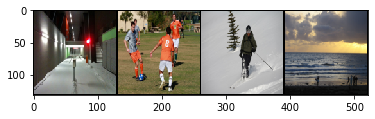

Ground Truth: ['traffic light', 'person', 'person', 'person']
Predicted: ['person', 'person', 'person', 'person']
Accuracy: 0.75


In [28]:
# Check several images.
dataiter = iter(valloader)
batch_size = 4
# for i in range(len(dataiter)):
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
# print(labels)
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print("Ground Truth:", [classes[labels[i]] for i in range(batch_size)])
print("Predicted:",[classes[predicted[i]] for i in range(batch_size)])
print("Accuracy:",sum(np.array(labels)==np.array(predicted.cpu()))/len(labels))

In [29]:
def topk_accuracy(k, labels, outputs):
    num_correct = 0
    _, predicted = outputs.topk(5, -1, largest=True, sorted=True)
    for idx, pred in enumerate(predicted):
#         print(labels[idx])
#         print(pred)
        if int(labels[idx]) in np.array(pred.cpu()): 
            num_correct += 1
    return num_correct

In [30]:
%%time
num_correct = 0
num_correct_k = 0
k = 5
# Check several images.
dataiter = iter(valloader)
batch_size = 4
for i in range(len(dataiter)):
    images, labels = dataiter.next()
    outputs = net(images.to(device))
    _, predicted = torch.max(outputs, 1)
    #     print(predicted)
    # print(labels)
    # print(predicted)
    num_correct_k += topk_accuracy(k, labels, outputs)
    num_correct += sum(np.array(labels)==np.array(predicted.cpu()))
    if i % 200 == 0:
        print("iteration",i)

iteration 0
iteration 200
iteration 400
iteration 600
iteration 800
iteration 1000
iteration 1200
CPU times: user 4.79 s, sys: 1.4 s, total: 6.19 s
Wall time: 21 s


In [31]:
print("Accuracy:", num_correct / (len(valloader) * batch_size))
print(f"Top {k} Accuracy:", num_correct_k / (len(valloader) * batch_size))

Accuracy: 0.31906300484652667
Top 5 Accuracy: 0.4460823909531502
